# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Импортируем необходимые библиотеки. 

In [1]:
%%capture
!pip install phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

rs = 998012

## Изучение данных

Загрузим датасет и изучим данные.

In [3]:
data = pd.read_csv('autos.csv')

In [4]:
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
23031,2016-04-05 08:37:03,1990,sedan,1999,manual,115,focus,150000,8,petrol,ford,no,2016-04-05 00:00:00,0,99097,2016-04-07 11:15:24
284519,2016-03-16 17:57:02,790,small,1999,manual,88,2_reihe,150000,8,petrol,peugeot,no,2016-03-16 00:00:00,0,41751,2016-03-17 16:17:47
75381,2016-04-02 23:55:49,499,small,1996,manual,58,NaN,150000,4,petrol,sonstige_autos,no,2016-04-02 00:00:00,0,10999,2016-04-03 06:48:20
162667,2016-03-05 14:21:37,3200,bus,2008,manual,88,note,150000,2,petrol,nissan,no,2016-03-04 00:00:00,0,55118,2016-03-05 17:35:05
152612,2016-03-12 13:56:29,18600,sedan,2013,manual,143,x_reihe,70000,1,gasoline,bmw,no,2016-03-12 00:00:00,0,33098,2016-03-12 13:56:29
53071,2016-03-20 16:48:59,7999,small,2009,manual,80,polo,60000,1,petrol,volkswagen,no,2016-03-20 00:00:00,0,92245,2016-04-06 22:44:29
342268,2016-03-06 22:38:21,2100,wagon,2003,manual,125,signum,150000,0,gasoline,opel,no,2016-03-06 00:00:00,0,51375,2016-03-19 17:16:35
5378,2016-03-06 16:39:22,14990,suv,2009,manual,163,xc_reihe,150000,3,gasoline,volvo,no,2016-03-06 00:00:00,0,79576,2016-04-06 21:17:13
348096,2016-04-02 23:52:17,0,sedan,1994,manual,136,mondeo,150000,9,NaN,ford,NaN,2016-04-02 00:00:00,0,51381,2016-04-07 06:16:59
45082,2016-03-26 17:57:42,6250,wagon,2004,auto,204,e_klasse,150000,11,gasoline,mercedes_benz,NaN,2016-03-26 00:00:00,0,40231,2016-04-06 06:46:18


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В нашем распоряжении датасет из 354369 записей и 16 признаков. Эти данные представляют из себя технические характеристики автомобилей, комплектации и цены. 

Для удобства в дальнейшей работе приведем столбцы к нижнему змеиному регистру.

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [8]:
rename_cols = {'vehicletype' : 'vehicle_type', 
               'registrationyear' : 'registration_year', 
               'registrationmonth' : 'registration_month',
               'fueltype' : 'fuel_type',
               'datecrawled' : 'date_crawled',
               'datecreated' : 'date_created',
               'numberofpictures' : 'number_of_pictures',
               'postalcode' : 'postal_code',
               'lastseen' : 'last_seen'
              }

In [9]:
data.rename(columns=rename_cols, inplace=True)

In [10]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Исследовательский анализ

Изучим гистограммы. 

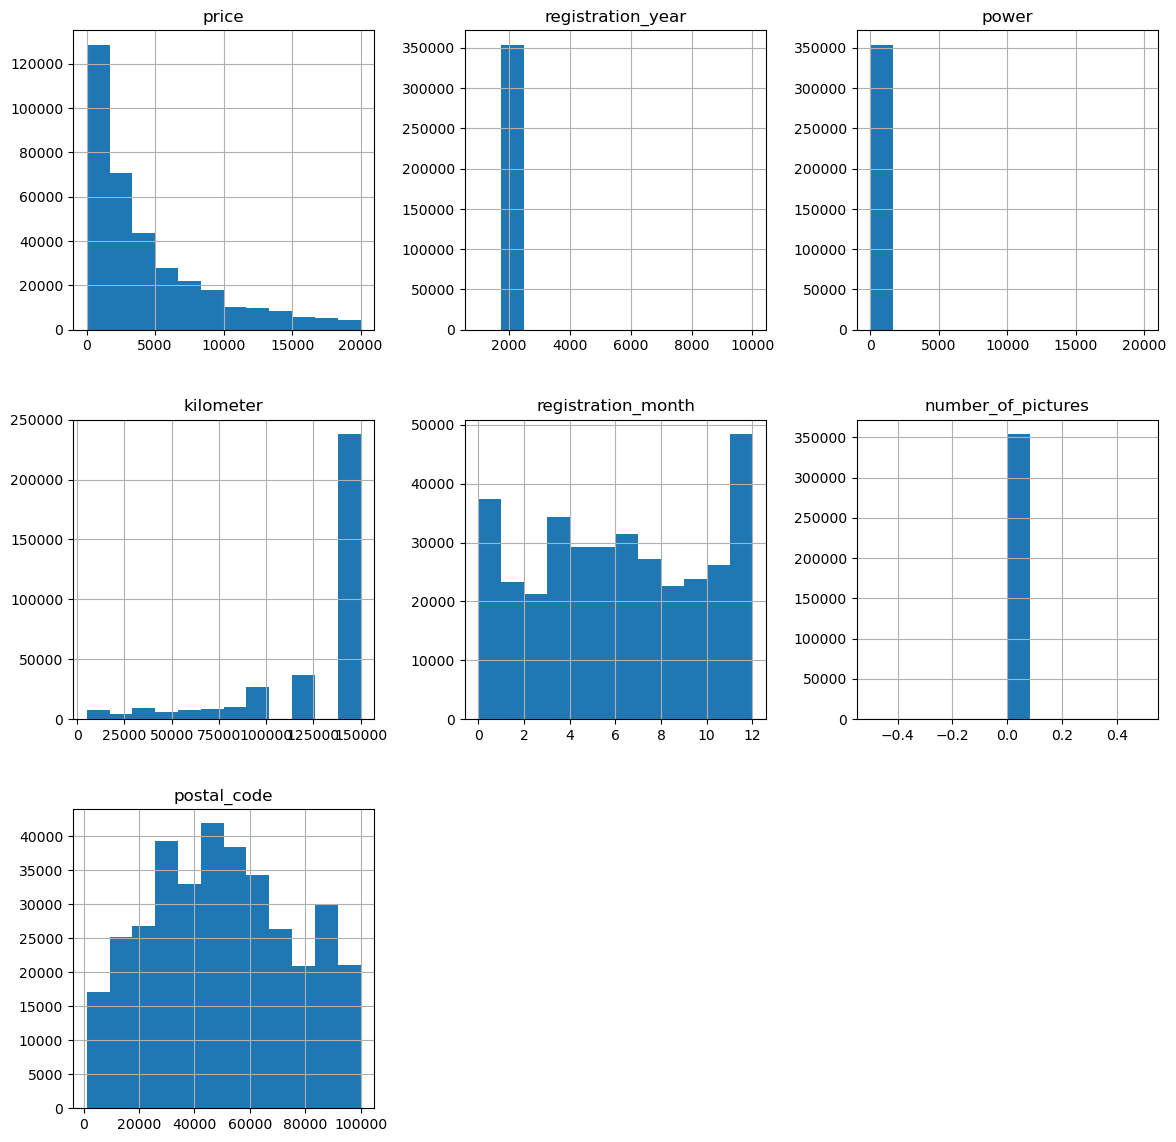

In [11]:
data.hist(bins=12, figsize=(14, 14))
None

На гистограммах видно, что многие столбцы имеют выбросы, которые нужно будет обработать.

Изучим статистики. 

In [12]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Минимальные и максимальные значения во многих колонках не являются адекватными (год : 1000 и 9999, месяц регистрации : 0, мощность : 0 и 200000 и тд). 

Визуализируем распределения в колонках с категориальными данными.

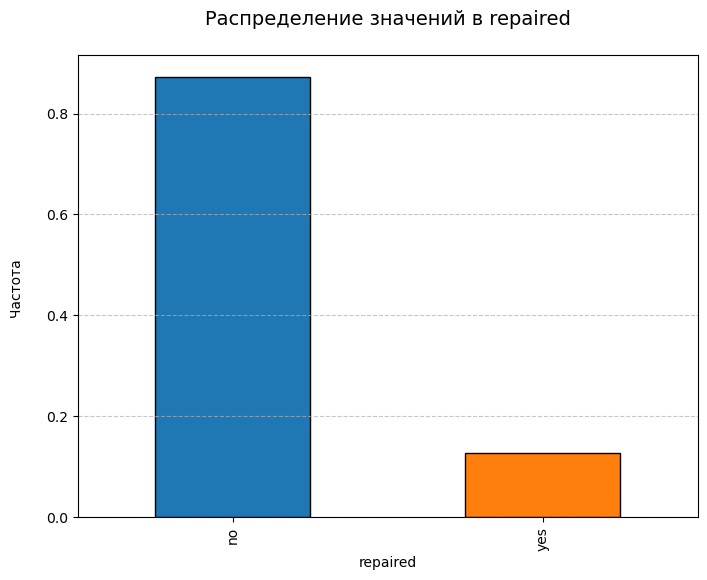

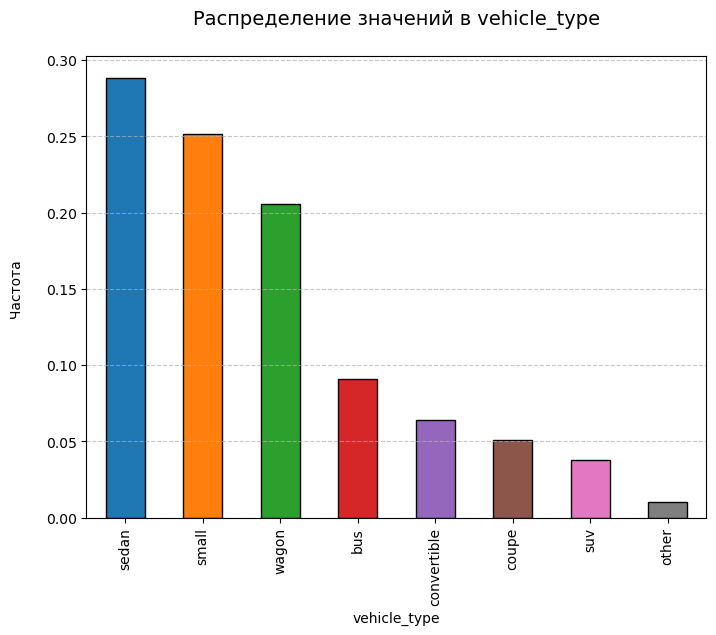

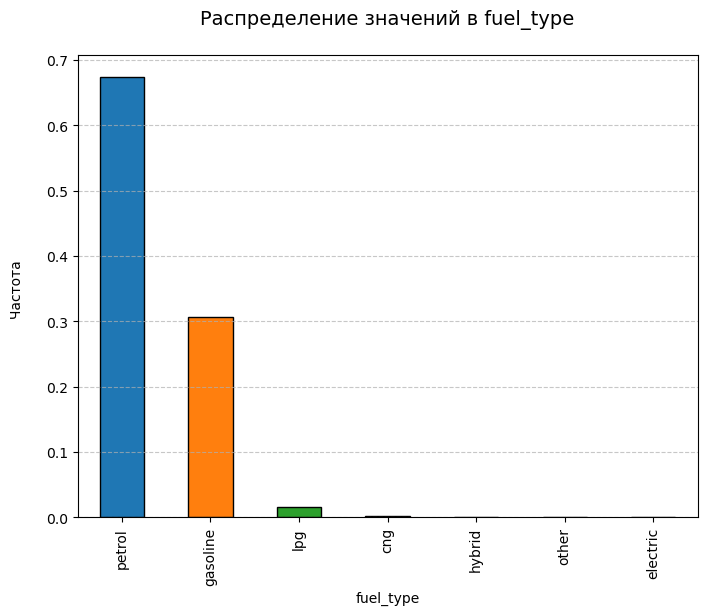

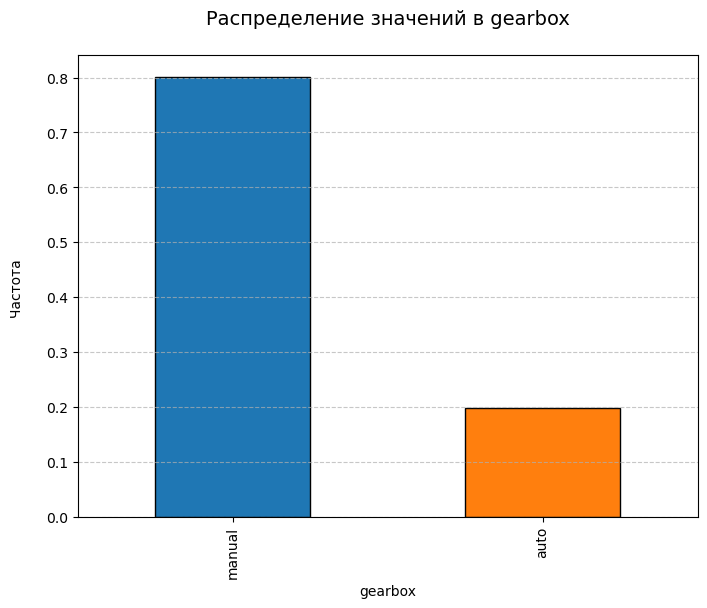

In [13]:
cols_to_visualize = ['repaired', 'vehicle_type', 'fuel_type', 'gearbox']
colors = ['C' + str(i) for i in range(0, 8)] 

for col in cols_to_visualize:
    data[col].value_counts(normalize=True).plot(kind='bar', edgecolor='black', stacked=True, color=colors, figsize=(8,6))
    plt.title(f'Распределение значений в {col}\n', size=14)
    plt.ylabel('Частота \n')
    plt.xlabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

1. Признак ремонта автомобиля :
- Большинство автомобилей не были ремонтированы.
- Менее 20% автомобилей из набора данных подверглись ремонту.
2. Тип кузова :
- Седаны (sedan) являются наиболее распространенным типом автомобиля.
- За ними идут маленькие автомобили (small) и универсалы (wagon).
- SUV-ы (suv) и другие типы (other) являются наименее популярными типами.
3. Тип топлива :
- Большинство автомобилей, почти 70%, работают на бензине.
- 30% автомобилей из датасета используют бензин.
- Электрические автомобили наименее популярны, всего 89 записей.
4. Коробка передач :
- 80% автомобилей оснащены механической коробкой передач.
- Оставшееся меньшинство имеет автоматическую коробку передач.

Изучим топ-10 популярных брендов и моделей авто. 

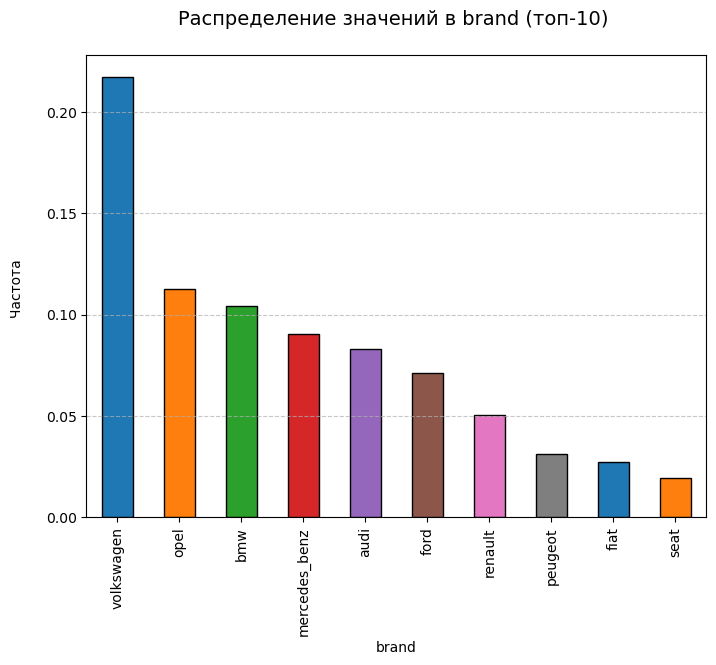

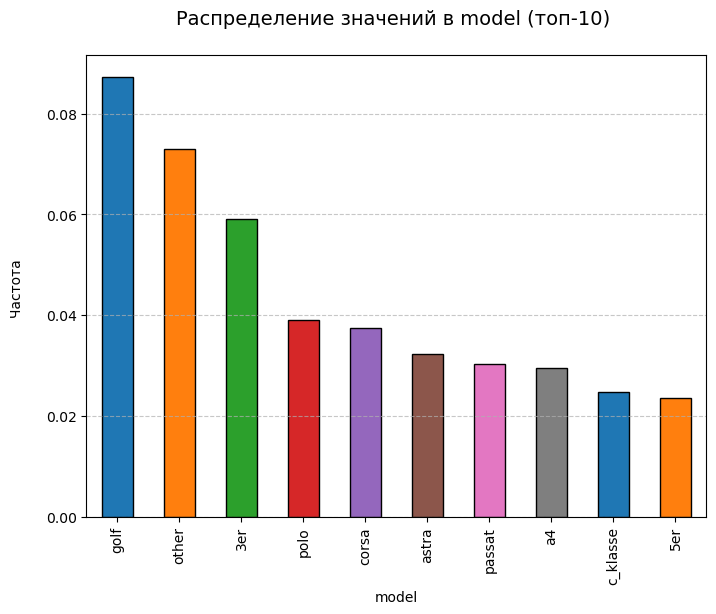

In [14]:
cols_to_visualize = ['brand', 'model']
colors = ['C' + str(i) for i in range(0, 8)] 

for col in cols_to_visualize:
    data[col].value_counts(normalize=True)[:10].plot(kind='bar', edgecolor='black', color=colors, figsize=(8,6))
    plt.title(f'Распределение значений в {col} (топ-10) \n', size=14)
    plt.ylabel('Частота \n')
    plt.xlabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

1. Марка :
- Наиболее популярной маркой среди представленных данных является "Volkswagen", составляющий приблизительно 21.4% всех записей.
- "Opel" и "BMW" следуют за ним с долями в 11.2% и 10.3% соответственно.
- Менее популярными марками в Топ-10 являются "Fiat" (2.75%) и "Seat" (1.97%).
2. Модель :
- "Golf" является наиболее популярной моделью, занимая примерно 8.58% всех записей.
- Модель "other" (неопределенный тип модели) имеет долю в 7.53% и стоит на втором месте.
- Модели "3er", "Polo", "Corsa", "Astra" и "Passat" также достаточно популярны. 

Рассмотрим матрицу корреляций и тепловую карту для информативных числовых столбцов.

In [15]:
# corr_matrix = data.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1).corr()

interval_cols = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']

corr_matrix = data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1).phik_matrix(
interval_cols = interval_cols)

corr_matrix

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
price,1.000000,0.268157,0.013889,0.323641,0.005752,0.579008,0.310844,0.185749,0.257367,0.355422,0.380373
vehicle_type,0.268157,1.000000,NaN,0.289237,0.011764,0.917251,0.172152,0.074611,0.330157,0.633333,0.084344
registration_year,0.013889,NaN,1.000000,0.003470,0.088713,0.083360,0.230438,0.031014,0.040116,0.051203,0.010072
gearbox,0.323641,0.289237,0.003470,1.000000,0.010497,0.647244,0.016474,0.047203,0.151407,0.520822,0.043662
power,0.005752,0.011764,0.088713,0.010497,1.000000,0.000000,0.000000,0.003228,0.010882,0.004458,0.011677
model,0.579008,0.917251,0.083360,0.647244,0.000000,1.000000,0.443418,0.150216,0.554911,0.998376,0.159132
kilometer,0.310844,0.172152,0.230438,0.016474,0.000000,0.443418,1.000000,0.056838,0.149136,0.275083,0.112929
registration_month,0.185749,0.074611,0.031014,0.047203,0.003228,0.150216,0.056838,1.000000,0.057718,0.109372,0.138240
fuel_type,0.257367,0.330157,0.040116,0.151407,0.010882,0.554911,0.149136,0.057718,1.000000,0.322331,0.044514
brand,0.355422,0.633333,0.051203,0.520822,0.004458,0.998376,0.275083,0.109372,0.322331,1.000000,0.105511


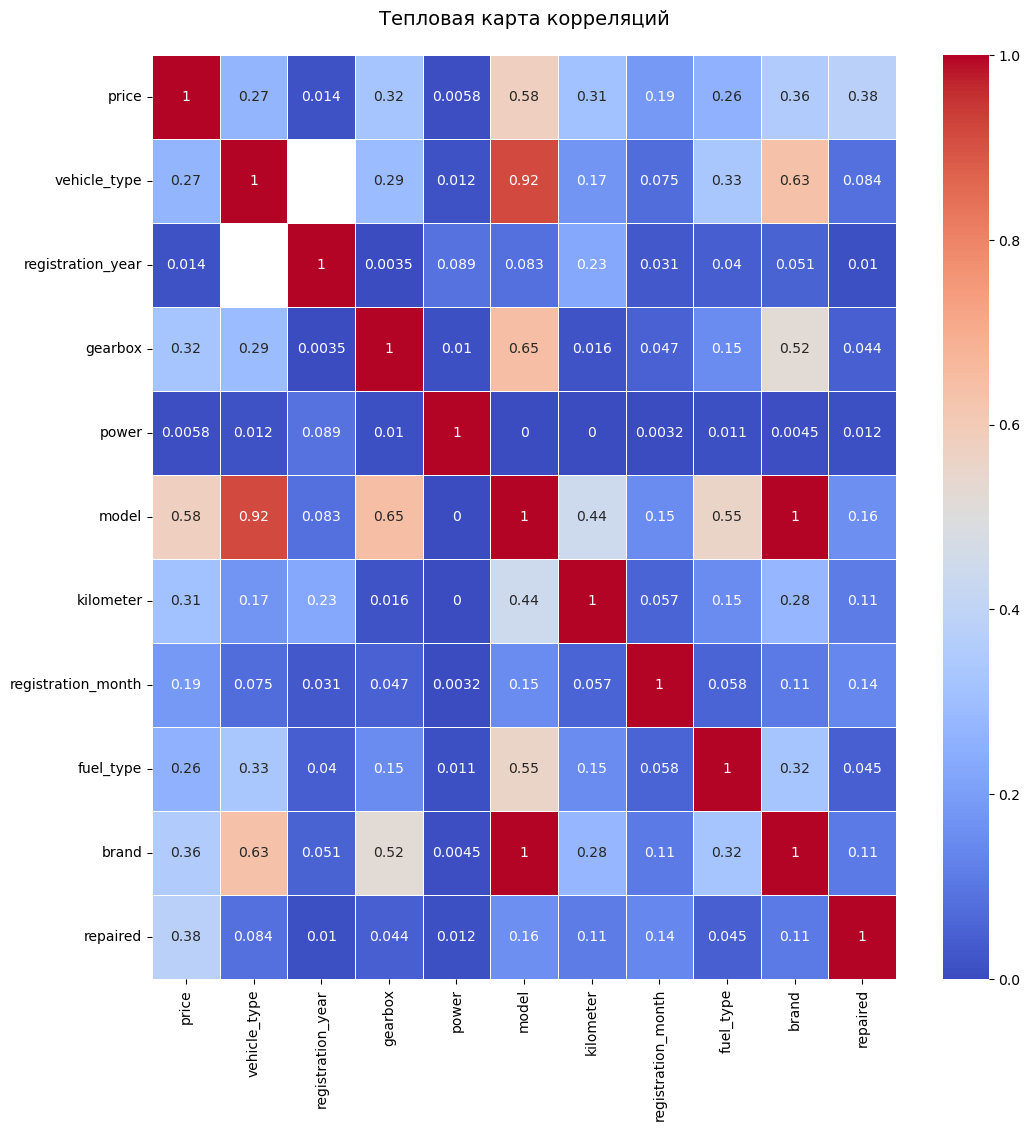

In [16]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Тепловая карта корреляций\n', size = 14)
plt.show()

<!---
Между числовыми данными нет явно выраженных корреляций, самый высокий показатель равен -0.33, т.е. между ценой и пробегом автомобиля имеется слабая отрицательная зависимость. 
-->

На матрице корреляций и тепловой карте видны некоторые взаимосвязи. Опишем их: 

1. Цена (price)
    - Сильная корреляция с model (0.58): Определенные модели автомобилей, вероятно, имеют разные ценовые категории.
    - Также есть заметная корреляция repaired (0.38). Так как коэффициент корреляции не показывает, какая именно связь существует между переменными, мы можем только предположить, что факт ремонта влияет на цену (вероятно в негативную сторону).
2. Тип кузова (vehicle_type):
    - Существует очень сильная корреляция с model (0.92): определенные модели автомобилей относятся к определенным типам кузова.
    - Также видна сильная корреляция с brand (0.64): бренды часто специализируются на определенных типах кузова. 
3. Год регистрации (registration_year):
    - В целом, этот параметр имеет очень низкую корреляцию с большинством других параметров, что может указывать на то, что год регистрации автомобиля не сильно связан с другими характеристиками.
    - Также можно заметить значения NaN, то есть для некоторых связей не хватило данных для рассчета коэффициента корреляции.
4. Коробка передач (gearbox):
    - Сильная корреляция с model (0.64): Определенные модели автомобилей обычно оснащены определенным типом коробки передач.
    - Также существует корреляция с brand (0.52) : Модели авто вероятно имеют определенный тип коробки передач.
5. Мощность (power):
    - Этот параметр не показывает корреляции с другими параметрами.
6. Модель (model):
    - Имеет идеальную положительную корреляция с brand: Это подтверждает, что каждая модель автомобиля соответствует определенному бренду.
    - Заметная корреляция с fuel_type (0.55): Определенные модели автомобилей могут чаще иметь определенный тип топлива.
    - Заметная корреляция с kilometer (0.44): Определенные модели автомобилей имеют разный средний пробег (возможно из-за года выпуска).
8. Месяц регистрации (registration_month):
    - Этот параметр имеет относительно низкую корреляцию с большинством других параметров.

### Вывод

- Загрузка данных:
    - Начальный датасет содержит 354369 записей и 16 признаков, которые представляют собой технические характеристики, комплектации и цены автомобилей.
    - Произведено приведение названий столбцов к нижнему змеиному регистру для удобства работы.
- Исследовательский анализ:
    - Анализ гистограмм показал, что во многих колонках есть выбросы.
    - Статистический анализ выявил неадекватные значения в некоторых колонках (например, годы регистрации 1000 и 9999).
    - Категориальные данные были визуализированы, были получены следующие выводы: 
        - большинство автомобилей не были ремонтированы, основной тип кузова – седан, основной тип топлива – бензин, и большинство автомобилей оснащены механической коробкой передач.
        - анализ топ-10 брендов и моделей показал, что Volkswagen, Opel и BMW являются наиболее популярными марками, а Golf, 3er и Polo наиболее популярными моделями в изучаемом датасете.
- Корреляционный анализ:
    - Цена автомобиля:
       - Существует сильная зависимость цены от модели автомобиля. Это может указывать на то, что определенные модели автомобилей находятся в определенном ценовом сегменте.
       - Факт ремонта также влияет на цену.
    - Тип кузова:
       - Определенные модели автомобилей чаще всего выпускаются в определенных типах кузова. Это подтверждается очень сильной корреляцией между моделью и типом кузова.
       - Бренды автомобилей также могут специализироваться на определенных типах кузова.
    - Год регистрации:
       - Год регистрации не имеет сильного влияния на другие характеристики автомобиля.
    - Коробка передач:
       - Определенные модели автомобилей, вероятно, чаще выпускаются с определенным типом коробки передач.
       - Связь между брендом и типом коробки передач также может говорить о том, что определенные бренды предпочитают определенные типы привода.
    - Мощность:
       - Мощность автомобиля не коррелирует с другими рассмотренными характеристиками.
    - Модель:
       - Каждая модель автомобиля однозначно соответствует определенному бренду, что подтверждается идеальной корреляцией.
       - Зависимость между моделью и типом топлива может говорить о том, что определенные модели предназначены для использования конкретного типа топлива.
       - Также существует связь между моделью и пробегом.
    - Месяц регистрации:
       - Месяц регистрации не имеет сильной корреляции с другими параметрами.

## Предобработка данных

### Удаление дубликатов

Для начала, перед предобработкой, удалим дубликаты в данных. При поиске дубликатов будем опираться только на информативные колонки. 

In [17]:
final_subset = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 
               'brand', 'repaired']

data.duplicated(subset=final_subset).sum()

45040

In [18]:
data.drop_duplicates(subset=final_subset, inplace=True)
data.reset_index(inplace=True, drop=True)

In [19]:
data.shape

(309329, 16)

### Обработка аномалий

#### Аномалии в `price`

Изучим аномалии в колонке с ценой автомобиля.

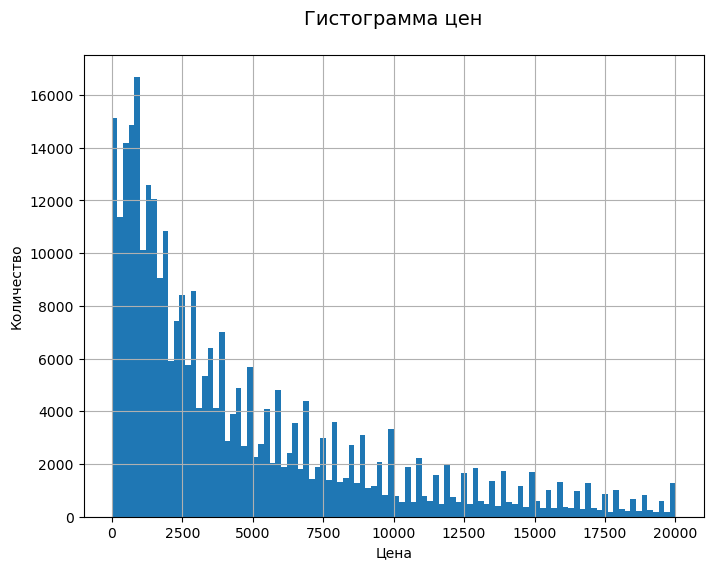

In [20]:
data['price'].hist(figsize=(8, 6), bins=100)
plt.title('Гистограмма цен\n', size=14)
plt.xlabel('Цена')
plt.ylabel('Количество')
None

На гистограмме видно, что наиболее частое значение цены лежит в районе 0. 

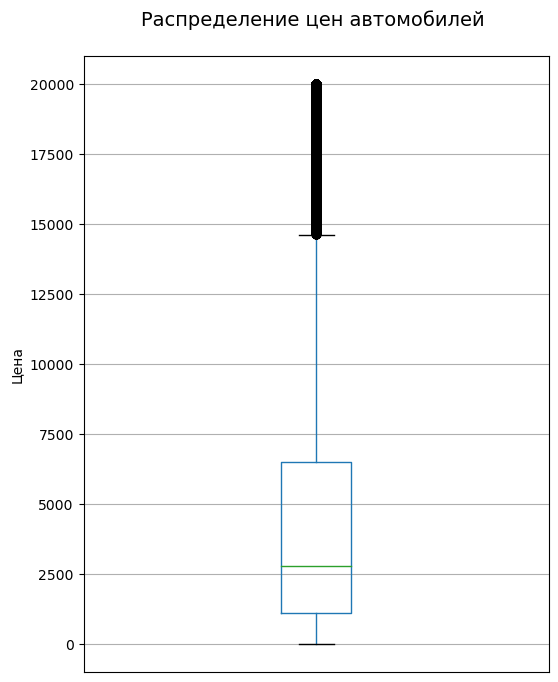

In [21]:
plt.figure(figsize=(6, 8))
data.boxplot(column='price')
plt.title('Распределение цен автомобилей \n', size=14)
plt.ylabel('Цена')
plt.xticks([])
None

На боксплоте также видно большое количество выбросов сверху. 

Изучим гистограмму цен в диапазоне 0-1000.

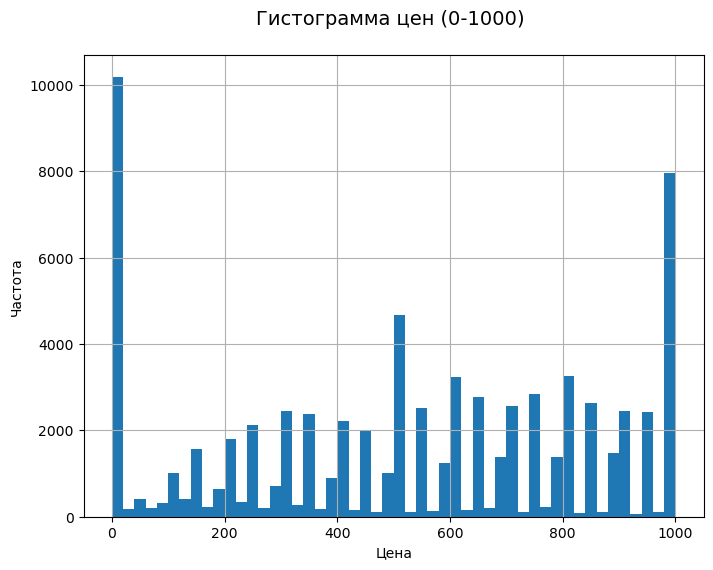

In [22]:
data['price'].hist(bins=50, figsize=(8, 6), range=(0, 1000))
plt.title('Гистограмма цен (0-1000) \n', size=14)
plt.xlabel('Цена')
plt.ylabel('Частота')
None

Виден пик в нуле. 

In [23]:
data.query('price < 500').shape[0] * 100 / data.shape[0]

10.352731234381515

<!-- 
Примерно 3.6% автомобилей в датасете имеют цену ниже 100.
-->

Примерно 10% автомобилей в датасете имеют цену ниже 500. Это достаточно большое количество, их удаление приведет к потере данных.

Заменим цены ниже 500 на 500 в датасете. Это может помочь избавиться от аномально низких цен. 

In [24]:
data['price'] = data['price'].apply(lambda x : 500 if x < 500 else x)

In [25]:
data['price'].describe()

count    309329.000000
mean       4518.206479
std        4535.991984
min         500.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

#### Аномалии в `registration_month`

Изучим записи, в которых в поле "месяц регистрации" записан 0. 

In [26]:
data.query('registration_month == 0').sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
102715,2016-03-28 18:25:18,600,small,1997,manual,60,golf,150000,0,petrol,volkswagen,yes,2016-03-28 00:00:00,0,56566,2016-04-01 03:17:51
277113,2016-03-29 15:51:06,500,NaN,2000,NaN,0,c_klasse,150000,0,NaN,mercedes_benz,NaN,2016-03-29 00:00:00,0,66287,2016-03-29 15:51:06
250654,2016-03-27 13:58:35,7200,wagon,2009,manual,140,passat,150000,0,gasoline,volkswagen,NaN,2016-03-27 00:00:00,0,44623,2016-04-07 09:46:34
185790,2016-03-28 17:39:07,1200,sedan,2000,manual,0,accord,150000,0,petrol,honda,no,2016-03-28 00:00:00,0,59425,2016-03-28 17:39:07
111929,2016-03-14 16:41:06,500,sedan,1995,manual,90,escort,150000,0,petrol,ford,no,2016-03-14 00:00:00,0,45663,2016-03-20 04:16:01
221197,2016-03-17 10:57:07,500,NaN,2000,manual,67,other,100000,0,petrol,suzuki,NaN,2016-03-17 00:00:00,0,89584,2016-04-04 08:17:30
227280,2016-03-15 17:38:19,1300,NaN,2005,NaN,197,c_klasse,150000,0,NaN,mercedes_benz,NaN,2016-03-15 00:00:00,0,10713,2016-03-15 17:38:19
80717,2016-03-26 18:44:15,1300,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-26 00:00:00,0,24214,2016-04-06 07:45:09
104908,2016-03-30 08:57:04,500,small,1997,manual,0,corsa,150000,0,NaN,opel,NaN,2016-03-30 00:00:00,0,96482,2016-04-01 02:17:54
141183,2016-03-10 14:57:42,1999,NaN,2018,NaN,0,mondeo,150000,0,gasoline,ford,NaN,2016-03-10 00:00:00,0,39576,2016-03-30 21:46:47


Заменим значение 0 на значение от 1 до 12 так, чтобы сохранить исходное распределение данных в колонце "месяц регистрации". 

In [27]:
month_distribution = data.query('registration_month > 0')['registration_month'].value_counts(normalize=True)
month_distribution

3     0.108434
6     0.099481
4     0.093514
5     0.092045
7     0.086202
10    0.081753
12    0.076363
11    0.075384
9     0.074865
1     0.073808
8     0.071090
2     0.067062
Name: registration_month, dtype: float64

In [28]:
sampled_months = np.random.choice(month_distribution.index, size=(data['registration_month'] == 0).sum(), p=month_distribution.values)
data.loc[data['registration_month'] == 0, 'registration_month'] = sampled_months

In [29]:
data['registration_month'].describe()

count    309329.000000
mean          6.376146
std           3.347738
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

Аномалии были обработаны. 

#### Аномалии в `registration_year`

Изучим аномалии в столбце "год регистрации". 

Построим гистограмму. 

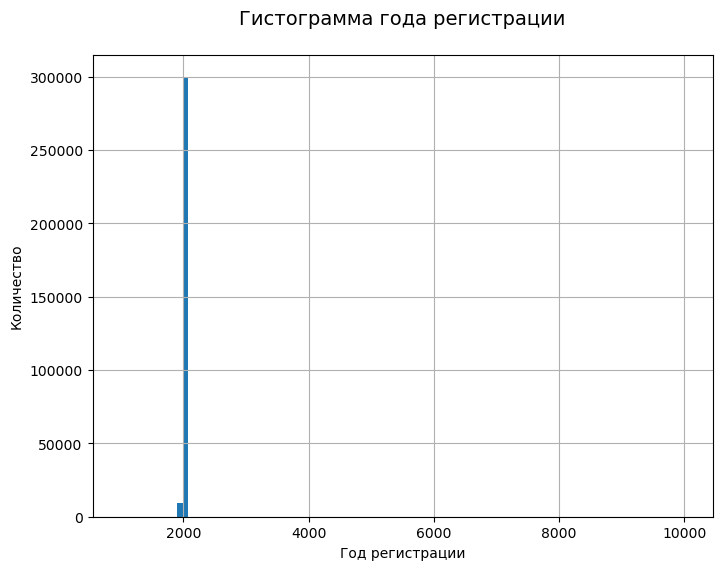

In [30]:
data['registration_year'].hist(figsize=(8, 6), bins=100)
plt.title('Гистограмма года регистрации\n', size=14)
plt.xlabel('Год регистрации')
plt.ylabel('Количество')
None

Как мы видели на этапе анализа данных, значения в данной колонце имеют большой разброс и много выбросов. 

Рассмотрим диаграмму с усами.

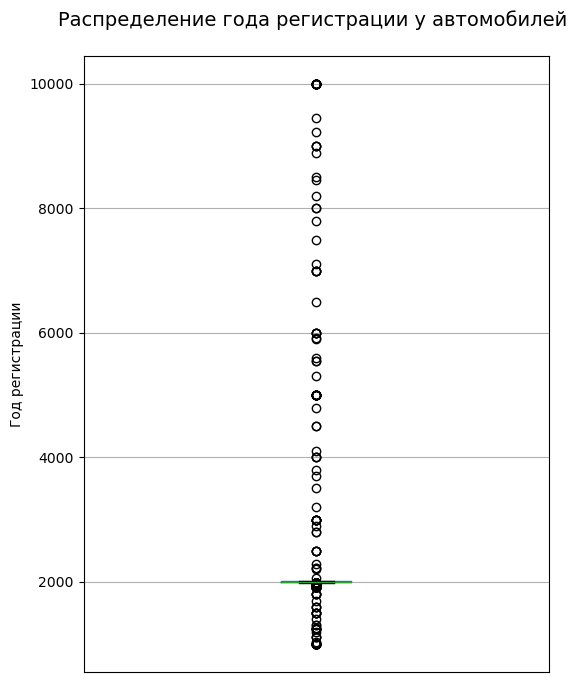

In [31]:
plt.figure(figsize=(6, 8))
data.boxplot(column='registration_year')
plt.title('Распределение года регистрации у автомобилей \n', size=14)
plt.ylabel('Год регистрации')
plt.xticks([])
None

Выбросы есть и снизу, и сверху.

Изучим гистограмму для 1800-1920 годов. 

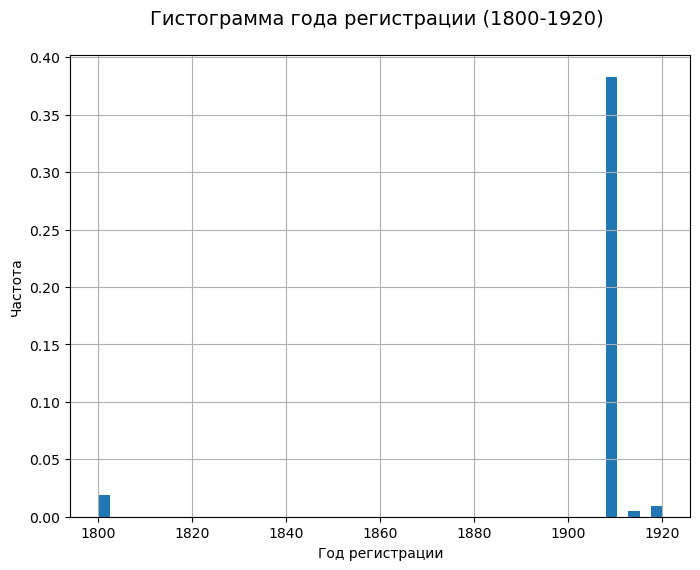

In [32]:
data['registration_year'].hist(bins=50, figsize=(8, 6), density=True, range=(1800,1920))
plt.title('Гистограмма года регистрации (1800-1920) \n', size=14)
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
None

Можно увидеть, что в районе 1800 года есть выбросы. Посмотрим, какие значения меньше 1920 есть в нашем датасете. 

In [33]:
data.query('registration_year <= 1920')['registration_year'].value_counts()

1910    80
1000    35
1500     5
1800     4
1234     4
1111     3
1300     2
1600     2
1919     1
1920     1
1915     1
1039     1
1001     1
1253     1
1688     1
1255     1
1200     1
1400     1
1602     1
Name: registration_year, dtype: int64

Примем 1910 год за нижнюю границу. 

Теперь изучим аномально большие значения. Максимальную границу найдем, рассмотрев данные из столбца date_crawled - дата скачивания анкеты из базы. 

In [34]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_crawled'].sample()

194456   2016-03-27 18:52:13
Name: date_crawled, dtype: datetime64[ns]

In [35]:
pd.DatetimeIndex(data['date_crawled']).year.max()

2016

Максимальным годом является 2016. Итоговый диапазон лет в нашем датасете (1910-2016)

Заменим все значения меньше 1910 года и больше 2016 на медианное значения по всем годам. 

In [36]:
median_year = data['registration_year'].median()

In [37]:
data['registration_year'] = data['registration_year'].apply(lambda x : x if 1910 <= x <= 2016 else median_year)

In [38]:
data['registration_year'].describe()

count    309329.000000
mean       2002.525896
std           7.087611
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

#### Аномалии в `power`

Изучим аномалии в столбце с мощностью. 

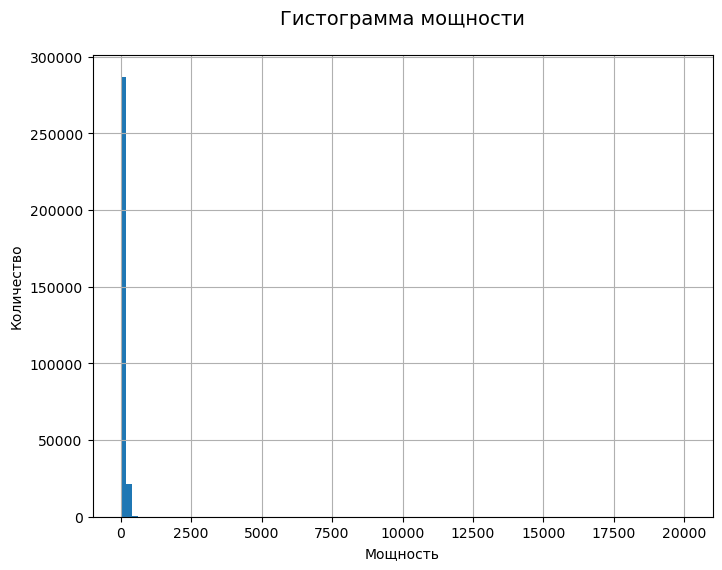

In [39]:
data['power'].hist(figsize=(8, 6), bins=100)
plt.title('Гистограмма мощности\n', size=14)
plt.xlabel('Мощность')
plt.ylabel('Количество')
None

Данные содержат выбросы, из-за этого гистограмма по всему набору неинформативна. 

Изучим боксплот для мощности. 

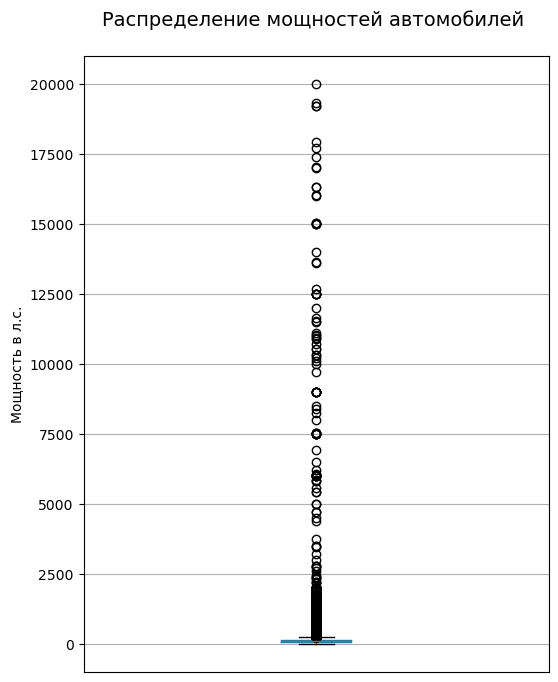

In [40]:
plt.figure(figsize=(6, 8))
data.boxplot(column='power')
plt.title('Распределение мощностей автомобилей \n', size=14)
plt.ylabel('Мощность в л.с.')
plt.xticks([])
None

В записях есть много аномально большим значений мощности. 

Изучим данные по срезам. Посмтроим гистограмму мощности для диапазона 500-1000. 

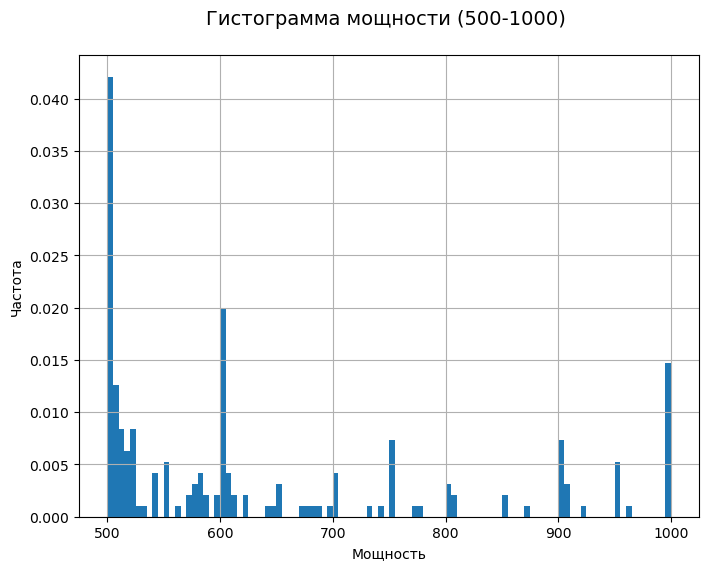

In [41]:
data['power'].hist(figsize=(8, 6), density=True, bins=100, range=(500, 1000))
plt.title('Гистограмма мощности (500-1000) \n', size=14)
plt.xlabel('Мощность')
plt.ylabel('Частота')
None

Можно предположить, что в случае аномально больших значений при ввроде данных пользователь перепутал мощность двигателя (в л.с.) и объем двигателя (в куб. см.) 

In [42]:
data.query('600 < power < 3500').sample(10).sort_values(by='power')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
210109,2016-03-11 18:36:24,1350,sedan,2000.0,manual,750,NaN,150000,9,NaN,volkswagen,yes,2016-03-11 00:00:00,0,38176,2016-03-12 23:16:50
249501,2016-03-21 14:54:41,1550,NaN,2016.0,manual,923,e_klasse,150000,8,NaN,mercedes_benz,no,2016-03-21 00:00:00,0,58540,2016-04-02 13:47:09
112895,2016-03-20 17:36:57,3000,small,2013.0,manual,1000,other,150000,11,petrol,ford,yes,2016-03-20 00:00:00,0,4626,2016-04-06 23:46:35
166053,2016-04-04 16:45:52,1100,sedan,1995.0,manual,1001,a4,150000,2,NaN,audi,no,2016-04-04 00:00:00,0,16259,2016-04-06 18:18:45
84799,2016-03-27 19:57:08,3750,wagon,2005.0,manual,1105,touran,150000,2,gasoline,volkswagen,NaN,2016-03-27 00:00:00,0,46238,2016-03-27 22:46:12
183793,2016-03-21 09:51:23,850,small,2002.0,manual,1199,corsa,150000,3,petrol,opel,no,2016-03-21 00:00:00,0,48167,2016-03-25 06:17:34
244498,2016-03-14 11:37:23,3500,convertible,2006.0,manual,1363,3_reihe,150000,4,gasoline,peugeot,NaN,2016-03-14 00:00:00,0,52355,2016-03-14 11:37:23
284170,2016-03-12 11:40:11,750,small,1999.0,manual,1400,a_klasse,150000,2,petrol,mercedes_benz,NaN,2016-03-12 00:00:00,0,24109,2016-03-13 02:44:15
35387,2016-04-01 01:56:06,5400,NaN,2003.0,manual,2017,transporter,150000,8,gasoline,volkswagen,NaN,2016-03-31 00:00:00,0,10178,2016-04-05 01:18:24
249937,2016-03-05 18:54:53,1999,small,2004.0,manual,2018,NaN,150000,12,petrol,renault,NaN,2016-03-05 00:00:00,0,59269,2016-03-06 03:17:21


Для данных в этом диапазоне восстановим мощность двигателя по приблизительной формуле "Мощность в ЛС = Объем двигателя в куб.см / 15", то есть мы предполагаем, что что каждые 15 куб.см. двигателя соответствуют одной лошадиной силе. 

In [43]:
data['power'] = data['power'].apply(lambda x : x // 15 if 600 < x < 3500 else x)

Изучим оставшиеся аномально низкие и высокие значения. Посмотрим гистограмму для диапазона 1-70. 

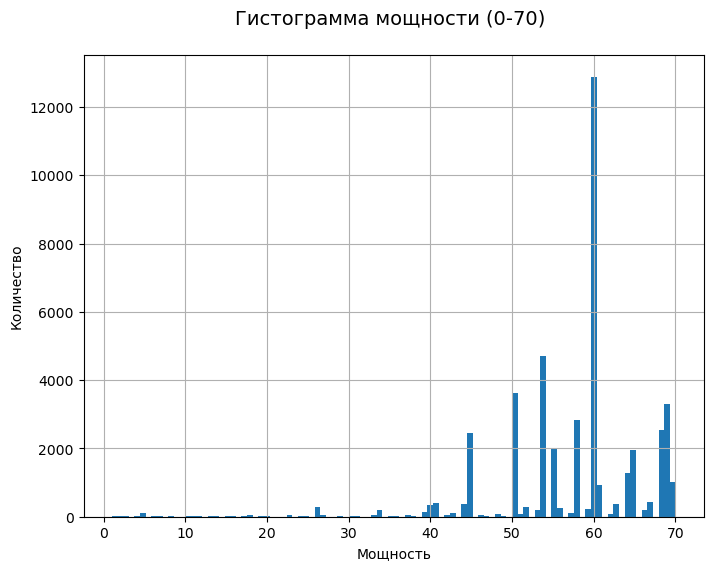

In [44]:
data['power'].hist(figsize=(8, 6), bins=100, range=(1, 70))
plt.title('Гистограмма мощности (0-70) \n', size=14)
plt.xlabel('Мощность')
plt.ylabel('Количество')
None

In [45]:
data.query('power < 45')['power'].shape[0] * 100 / data.shape[0]

12.487998215492244

Датасет содержит 12% записей с мощностью меньше 45. 

Построим гистограмму для значений 3500-20000. 

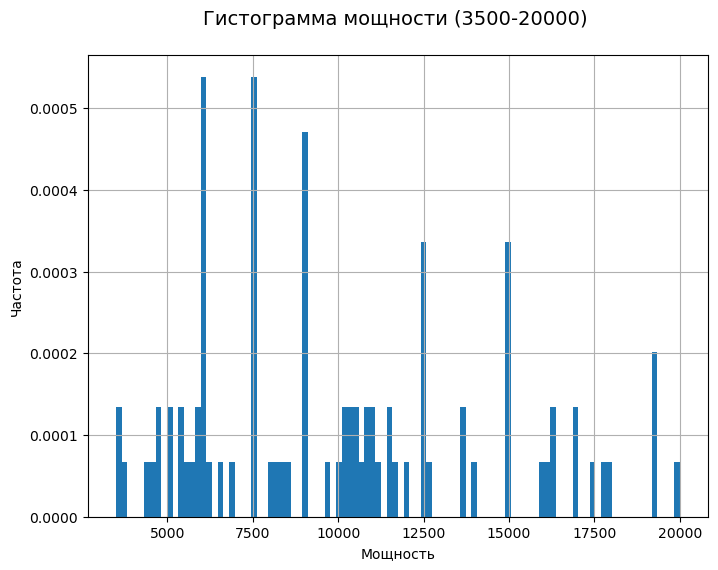

In [46]:
data['power'].hist(figsize=(8, 6), bins=100, density=True, range=(3500, 20000))
plt.title('Гистограмма мощности (3500-20000) \n', size=14)
plt.xlabel('Мощность')
plt.ylabel('Частота')
None

Возможно, аномально большие значения также связаны с ошибкой ввода : вместо значения мощности в лошадиных силах пользователь мог ввести значение максимальных оборотов двигателя.  

Заменим значения лежащие в диапазоне от 0 до 45 и более 3500 на медианное значение для группы "марка авто". 

In [47]:
median_power_by_brand = data.query('power < 3500').groupby('brand')['power'].median()

In [48]:
def replace_anomalous_power(row):
    if row['power'] >= 3500 or row['power'] < 45:
        return median_power_by_brand[row['brand']]
    else:
        return row['power']

In [49]:
data['power'] = data.apply(replace_anomalous_power, axis=1)

In [50]:
data['power'].describe()

count    309329.000000
mean        118.913715
std          51.886360
min          26.000000
25%          81.000000
50%         109.000000
75%         143.000000
max         600.000000
Name: power, dtype: float64

In [51]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,309329.000000,309329.000000,309329.000000,309329.000000,309329.000000,309329.0,309329.000000
mean,4518.206479,2002.525896,118.913715,127217.735809,6.376146,0.0,50720.535223
std,4535.991984,7.087611,51.886360,38532.941010,3.347738,0.0,25829.182828
min,500.000000,1910.000000,26.000000,5000.000000,1.000000,0.0,1067.000000
25%,1100.000000,1999.000000,81.000000,125000.000000,4.000000,0.0,30179.000000
50%,2800.000000,2003.000000,109.000000,150000.000000,6.000000,0.0,49497.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71522.000000
max,20000.000000,2016.000000,600.000000,150000.000000,12.000000,0.0,99998.000000


Аномалии в столбце с мощностью были обработаны. 

### Обработка пропусков

Изучим пропуски в данных.

In [52]:
pd.DataFrame({
    'missing_values_number': data.isna().sum(), 
    'missing_values_percentage': (data.isna().sum() * 100 / data.shape[0]).apply(lambda x : "{:.2f}%".format(x))
}).sort_values(by='missing_values_number', ascending=False)

,missing_values_number,missing_values_percentage
repaired,64558,20.87%
vehicle_type,34559,11.17%
fuel_type,30764,9.95%
model,18361,5.94%
gearbox,17207,5.56%
date_crawled,0,0.00%
price,0,0.00%
registration_year,0,0.00%
power,0,0.00%
kilometer,0,0.00%


В данных очень много пропусков, в 5 столбцах. Удаление их приведет к потере большого количества информации. 

Необходимо понять, как заполнить пропуски. Проверим, можно ли определить тип автомобиля исходя из марки и модели. 

In [53]:
data.groupby(['brand', 'model'])['vehicle_type'].nunique().sample(5)

brand       model 
hyundai     other     8
volkswagen  beetle    6
opel        omega     6
volvo       v60       2
toyota      yaris     5
Name: vehicle_type, dtype: int64

У одной и той же марки и модели могут быть разные типы кузова, следовательно опираться на эти данные для заполнения пропусков нельзя.

Заполним пропуски в каждом столце категорией "unknown". 

In [54]:
data.fillna('unknown', inplace=True)

In [55]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309329 entries, 0 to 309328
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        309329 non-null  datetime64[ns]
 1   price               309329 non-null  int64         
 2   vehicle_type        309329 non-null  object        
 3   registration_year   309329 non-null  float64       
 4   gearbox             309329 non-null  object        
 5   power               309329 non-null  float64       
 6   model               309329 non-null  object        
 7   kilometer           309329 non-null  int64         
 8   registration_month  309329 non-null  int64         
 9   fuel_type           309329 non-null  object        
 10  brand               309329 non-null  object        
 11  repaired            309329 non-null  object        
 12  date_created        309329 non-null  object        
 13  number_of_pictures  309329 no

### Удаление неинформативных столбцов

Удалим столбцы, которые не помогут модели с предсказанием цены. 

In [57]:
data = data[final_subset]

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309329 entries, 0 to 309328
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              309329 non-null  int64  
 1   vehicle_type       309329 non-null  object 
 2   registration_year  309329 non-null  float64
 3   gearbox            309329 non-null  object 
 4   power              309329 non-null  float64
 5   model              309329 non-null  object 
 6   kilometer          309329 non-null  int64  
 7   fuel_type          309329 non-null  object 
 8   brand              309329 non-null  object 
 9   repaired           309329 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 23.6+ MB


### Вывод

- Удаление дубликатов:
    - Дубликаты были отобраны по набору признаков, которые будут использованы при обучении моделей.
    - В итоговом наборе осталось 309329 записей, дубликаты составляли 13% данных.  
    
В ряде столбцов были обнаружены аномально низкие и высокие значения, была проведена их обработка.

- Цена:
    - Произведена замена значений меньше 500 на значение 500, чтобы избавиться от аномально низких значений.
    - Высокие значения было решено не обрабатывать, так они могут отражать реальные характеристики редких авто или моделей премиум-класса, и их коррекция может исказить общую картину данных.
- Месяц регистрации:
    - Выявлены записи с нулевым значением месяца регистрации.
    - Эти значения были заменены в соответствии с исходным распределением данных в этом столбце.
- Год регистрации:
    - В результате анализа в качестве нижней границы принят 1910 год, а верхней - 2016 год.
    - Значения, выходящие за эти границы, были заменены на медианное значение.
- Мощность:
    - Выявлены аномально высокие значения мощности, предположительно из-за того, что пользователь мог при вводе мог перепутать мощность двигателя (в л.с.) и объем двигателя (в куб. см.). Для зачений в дианапозе от 600 до 3500 была применена формула коррекции (ЛС = См3 / 15).
    - Также были обработаны оставшиеся аномально низкие и высокие значения мощности (меньше 45 и больше 3500) путем заменены на медианное значение для группы по марке автомобиля.
- Заполнение пропуков
    - Так как невозможно заполнить отсутствующие значения адекватным путем, а удаление их приведет к потере большого количества данных, было решено заполнить пропуски категорией "unknown".
    
Также для дальнейших этапов в датасете были оставлены только информативные признаки, которые модели смогут использовать для обучения. 

## Обучение моделей

### Подготовка выборок

Подготовим отдельный датафрейм с OHE-закодированными данными для линейных моделей. 

Мы будем обучать модели, основанные на разных алгоритмах машинного обучения. Для каждого типа подготовим свои наборы признаков и таргетов. Благодаря использованию параметра `random_state` данные разделятся одинаково при каждом разделении, что обеспечит воспроизводимость результатов и упростит сравнение различных моделей.  
Данные разделим на обучающую и тестовую выборки в соотношении 75/25, тк затем мы будем использовать GridSearch для подбора гиперпараметров.  

**OHE-закодированные данные для линейной регрессии** 

In [59]:
features_ohe = data.drop('price', axis=1)
target_ohe = data['price']

In [60]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=.25, random_state=rs) 

In [61]:
features_train_ohe.sample(5)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
51089,sedan,1997.0,manual,101.0,passat,150000,petrol,volkswagen,unknown
64488,wagon,1999.0,manual,110.0,other,150000,petrol,citroen,no
70581,wagon,1996.0,unknown,90.0,astra,150000,petrol,opel,no
5232,small,2006.0,manual,69.0,yaris,125000,petrol,toyota,no
20627,small,2001.0,manual,50.0,polo,150000,petrol,volkswagen,no


In [62]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'kilometer', 'registration_year']
num_features = ['power']

features_train_ohe_cat = encoder.fit_transform(features_train_ohe[cat_features])
features_test_ohe_cat = encoder.transform(features_test_ohe[cat_features])

encoded_feature_names = encoder.get_feature_names_out(cat_features)

cat_features_train_df = pd.DataFrame(features_train_ohe_cat, columns=encoded_feature_names)
cat_features_test_df = pd.DataFrame(features_test_ohe_cat, columns=encoded_feature_names)

features_train_ohe = pd.concat([cat_features_train_df.reset_index(drop=True), features_train_ohe[num_features].reset_index(drop=True)], axis=1)

features_test_ohe = pd.concat([cat_features_test_df.reset_index(drop=True), features_test_ohe[num_features].reset_index(drop=True)], axis=1)

C:\Users\baby_\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<!-- Масштибируем данные, чтобы избежать ситуации, при которой алгоритм ML присвоит столбцам с большими значениями и разбросами более высокие веса (т.е. посчитает, что эти столбцы важнее).
 
numeric = ['registration_year', 'power', 'kilometer', 'registration_month']

scaler = StandardScaler()

scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
--> 

Так как у нас остался только один числовой столбец, масштабирование делать не нужно. 

In [63]:
scaler = StandardScaler()

scaler.fit(features_train_ohe[num_features])

features_train_ohe[num_features] = scaler.transform(features_train_ohe[num_features])
features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])

In [64]:
features_train_ohe.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,...,registration_year_2008.0,registration_year_2009.0,registration_year_2010.0,registration_year_2011.0,registration_year_2012.0,registration_year_2013.0,registration_year_2014.0,registration_year_2015.0,registration_year_2016.0,power
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.868541
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.135572
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.846517
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.598757
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.135572


**Данные для CatBoost и LightGBM**  

Так как обе эти библиотеки умеют работать с категориальными данными, нам не нужно явно кодировать категориальные признаки. Основные компоненты как в LightGBM, так и в CatBoost — это деревья решений ; они базируются на пороговых значениях признаков для разбиения данных, и масштабирование признаков не повлияет на обучение модели. 

In [65]:
features = data.drop('price', axis=1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=rs) 

In [66]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
124442,unknown,2003.0,manual,164.0,c_klasse,150000,petrol,mercedes_benz,no
174643,sedan,2004.0,manual,60.0,corsa,150000,petrol,opel,unknown
235751,sedan,1996.0,manual,75.0,unknown,150000,petrol,volkswagen,no
72526,bus,2012.0,manual,150.0,c_max,30000,petrol,ford,no
135157,small,1996.0,manual,60.0,1_reihe,150000,petrol,peugeot,no


**Данные для случайного леса**  

Для данного алгоритма нам понадобится преобразовать категориальные данные в числовые значения. Для того, чтобы упростить процесс обучения модели, вместо OHE-кодирования, при использовании которого датафрейм разрастется вширь, используем Ordinal-encoding. Каждой уникальной категории присвоится числовое значение.

In [67]:
features_rf = data.drop('price', axis=1)
target_rf = data['price']

features_train_rf, features_test_rf, target_train_rf, target_test_rf = train_test_split(
    features_rf, target_rf, test_size=.25, random_state=rs) 

In [68]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_rf[cat_features] = encoder.fit_transform(features_train_rf[cat_features])
features_test_rf[cat_features] = encoder.transform(features_test_rf[cat_features])

In [69]:
features_train_rf.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
124442,7.0,81.0,1.0,164.0,59.0,12.0,6.0,20.0,0.0
174643,4.0,82.0,1.0,60.0,83.0,12.0,6.0,24.0,1.0
235751,4.0,74.0,1.0,75.0,227.0,12.0,6.0,38.0,0.0
72526,0.0,90.0,1.0,150.0,60.0,3.0,6.0,10.0,0.0
135157,5.0,74.0,1.0,60.0,5.0,12.0,6.0,25.0,0.0


Приступим к обучению моделей.  

### Случайный лес 

In [70]:
%%time

param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [4, 6, 10]
}
    
model = RandomForestRegressor(random_state=rs)
    
random_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

random_search.fit(features_train_rf, target_train_rf)

print(f"Параметры лучшей модели случайного леса: {random_search.best_params_}")
print(f"RMSE для лучшей модели случайного леса: {np.sqrt(-random_search.best_score_)}")
print()

Параметры лучшей модели случайного леса: {'max_depth': 10, 'n_estimators': 100}
RMSE для лучшей модели случайного леса: 2039.4675387788748

CPU times: total: 20.7 s
Wall time: 1min 41s


### Линейная регрессия

In [71]:
%%time

model = LinearRegression()

scores = cross_val_score(model, features_train_ohe, target_train_ohe, cv=3, scoring='neg_mean_squared_error')      

print(f"RMSE для линейной регрессии: {np.sqrt(-scores.mean())}")
print()

RMSE для линейной регрессии: 2220.5365963134054

CPU times: total: 22.6 s
Wall time: 13.2 s


### LightGBM

In [72]:
%%time

for feature in cat_features:
    features_train[feature] = features_train[feature].astype('category')
    features_test[feature] = features_test[feature].astype('category')

param_grid = {
    'learning_rate': [0.03, 0.1],
    'max_depth': [4, 6, 10],
    'n_estimators': [30, 50, 100]
}

model = LGBMRegressor(random_state=rs)

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

grid_search.fit(features_train, target_train)

print(f"Параметры лучшей модели LightGBM: {grid_search.best_params_}")
print(f"RMSE для лучшей модели LightGBM: {np.sqrt(-random_search.best_score_)}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 231996, number of used features: 9
[LightGBM] [Info] Start training from score 4522.750655
Параметры лучшей модели LightGBM: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE для лучшей модели LightGBM: 2039.4675387788748
CPU times: total: 2.66 s
Wall time: 21.6 s


### CatBoost

In [73]:
%%time

categorical_indices = [features_train.columns.get_loc(col) for col in cat_features]

for f in cat_features:
    features_train[f] = features_train[f].astype(str)

param_grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'iterations' : [30, 50, 100]
}

model = CatBoostRegressor(cat_features=categorical_indices, random_state=rs, verbose=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(features_train, target_train)

print(f"Параметры лучшей модели CatBoost: {grid_search.best_params_}")
print(f"RMSE для лучшей модели CatBoost: {np.sqrt(-grid_search.best_score_)}")
print()

Параметры лучшей модели CatBoost: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
RMSE для лучшей модели CatBoost: 1867.5241263825671

CPU times: total: 53.1 s
Wall time: 3min 16s


### Вывод

- Подготовка выборок:
    - Данные были разделены на обучающую и тестовую выборки в соотношении 75/25.
    - Был использован параметр random_state для обеспечения воспроизводимости разделения данных, что упростит сравнение результатов различных моделей.
- Подготовка данных:
    - Для линейной регрессии данные были OHE-закодированы.
    - Для CatBoost и LightGBM категориальные признаки были оставлены без изменений, так как обе библиотеки эффективно работают с ними напрямую.
    - Для случайного леса категориальные данные были преобразованы в числовые с помощью Ordinal-encoding. 
- Стратегии обучения:
    - Для всех моделей использован GridSearch для оптимизации гиперпараметров.
- Результаты обучения. RMSE:
    - Случайный лес: 2039.5
    - Линейная регрессия: 2220.5
    - LightGBM: 2039.5
    - CatBoost: 1867.5
- Выводы по результатам обучения:
    - Все модели показали результат лучше, чем указан в требованиях (RMSE < 2500) 
    - Наилучшее значение метрики показала модель **CatBoost**, однако подбор гиперпараметрова для нее занял наибольшее время
    - Случайный лес и LightGBM показали одинаковые результаты.

## Анализ моделей

### Время обучения, время предсказания и качество на обучающей выборке. 

Используем значения гиперпараметров, полученных на предыдущем этапе и проанализируем время обучения, предсказания и качество моделей на обучающей выборке. 

#### Случайный лес

In [74]:
%%time

random_forest = RandomForestRegressor(random_state=rs, max_depth=10, n_estimators=100)

random_forest.fit(features_train_rf, target_train_rf);

CPU times: total: 21 s
Wall time: 23.3 s


In [75]:
%%time

predicted = random_forest.predict(features_train_rf)

mean_squared_error(target_train_rf, predicted, squared=False)

CPU times: total: 1.28 s
Wall time: 1.64 s


1953.4994054319093

**Линейная регрессия**

In [76]:
%%time

linear_regression = LinearRegression()

linear_regression.fit(features_train_ohe, target_train_ohe);

CPU times: total: 9.16 s
Wall time: 6.4 s


In [77]:
%%time

predicted = linear_regression.predict(features_train_ohe)

mean_squared_error(target_train_ohe, predicted, squared=False)

CPU times: total: 234 ms
Wall time: 225 ms


2210.087155307898

#### LightGBM

In [78]:
%%time 

for feature in cat_features:
    features_train[feature] = features_train[feature].astype('category')

lightgbm = LGBMRegressor(random_state=rs, learning_rate=0.1, max_depth=10, n_estimators=100)

lightgbm.fit(features_train, target_train);

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 231996, number of used features: 9
[LightGBM] [Info] Start training from score 4522.750655
CPU times: total: 1.47 s
Wall time: 804 ms


In [79]:
%%time

predicted = lightgbm.predict(features_train)

mean_squared_error(target_train, predicted, squared=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 812 ms
Wall time: 412 ms


1722.524030305084

#### CatBoost

In [80]:
%%time 

for f in cat_features:
    features_train[f] = features_train[f].astype(str)

catboost = CatBoostRegressor(cat_features=categorical_indices, random_state=rs, verbose=0, learning_rate=0.1, max_depth=10, 
                             n_estimators=100)

catboost.fit(features_train, target_train);

CPU times: total: 9.14 s
Wall time: 14.5 s


In [81]:
%%time

predicted = catboost.predict(features_train)

mean_squared_error(target_train, predicted, squared=False)

CPU times: total: 734 ms
Wall time: 683 ms


1801.0443224173196

#### Промежуточный вывод

- **Случайный лес (RandomForestRegressor)**:
    - Время обучения: 23.3 секунды.
    - Время предсказания: 1.64 секунды.
    - RMSE на обучающей выборке: 1953.5
    
- **Линейная регрессия**:
    - Время обучения: 6.4 секунд.
    - Время предсказания: 225 миллисекунд (0.225 секунды).
    - RMSE на обучающей выборке: 2210.09

- **LightGBM**:
    - Время обучения: 804 миллисекунд (0.804 секунды).
    - Время предсказания: 412 миллисекунд (0.412 секунды).
    - RMSE на обучающей выборке: 1722.52

- **CatBoost**:
    - Время обучения: 14.5 секунд.
    - Время предсказания: 683 миллисекунд (0.683 секунды).
    - RMSE на обучающей выборке: 1801.04
    
Общий вывод:  

- LightGBM показывает наилучшие результаты с точки зрения времени (наиболее быстрая модель как в обучении, так и в предсказании) и качества (наименьший RMSE на обучающей выборке).
- CatBoost также показывает хорошие результаты, но он медленнее, чем LightGBM, и RMSE немного выше.
- Случайный лес требует наибольшее время на обучение и предсказание.  
- Линейная регрессия, хоть и работает быстро, показывает значительно худший RMSE по сравнению с остальными моделями.

Таким образом, если быстродействие и точность являются приоритетами, рекомендуется выбрать **LightGBM**. 

### Проверка на тестовой выборке.  

Проверим модель LightGBM на тестовой выборке. 

In [84]:
for feature in cat_features:
    features_test[feature] = features_test[feature].astype('category')

predicted_test = lightgbm.predict(features_test)

print(f'RMSE для CatBoost на тестовых данных: {mean_squared_error(target_test, predicted_test, squared=False)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE для CatBoost на тестовых данных: 1796.0974806420988


Результат на тестовой выборке намного лучше обозначенного в требованиях.

Для проверки адекватности модели сравним этот результат с предсказаниями базовой модели, которая всегда отдает среднее значение. 

In [85]:
dummy = DummyRegressor(strategy="mean").fit(features_train, target_train)

predicted = dummy.predict(features_test)

print(f'RMSE для DummyRegressor: {mean_squared_error(target_test, predicted, squared=False)}')

RMSE для DummyRegressor: 4531.776591741886


RMSE базовой модели намного хуже, чем у нашей модели, следовательно, проверка на адекватность пройдена. 

## Вывод по проекту

1. Загрузка и предварительная обработка данных:
- Исходный датасет содержал 354369 записей и 16 признаков.
- Были проведены преобразования названий столбцов.
2. Исследовательский анализ:
- Большинство автомобилей в датасете не были ремонтированы, имели тип кузова "седан", работали на бензине и оснащены механической коробкой передач.
- Наиболее популярными марками оказались Volkswagen, Opel и BMW, а наиболее популярными моделями (из определенных) - Golf, 3er и Polo.
- Также было обнаружено присутствие выбросов во многих столбцах
3. Предобработка данных
- Обработка аномалий:
    - В колонке "Цена" аномально низкие значения были заменены на 500.
    - В колонке "Месяц регистрации" нулевые значения были заменены в соответствии с исходным распределением.
    - В колонке "Год регистрации" были установлены границы от 1910 до 2016 года включительно.
    - В колонке "Мощность" была проведена коррекция аномально высоких значений, а также обработка аномально низких и высоких значений. Итоговый диапазон : 26-600 л.с. 
- Обработка пропусков:
    - В связи с отсутствием возможности адекватного заполнения пропусков и необходимостью сохранить данные, пропуски были заполнены категорией "unknown".
- Удаление дубликатов
    - Были найдены и удалены дубликаты для столбцов, которые затем будут использованы в обчении моделей. В итоговом датасете осталось 309329 записей (13% дубликатов было удалено). 
4. Обучение моделей:
- Подготовка выборок:
    - Данные были разделены на обучающую и тестовую выборки в соотношении 75/25.
    - Был использован параметр random_state для обеспечения воспроизводимости разделения данных, что упростит сравнение результатов различных моделей.
- Подготовка данных для различных моделей:
    - Для линейной регрессии данные были OHE-закодированы.
    - Для CatBoost и LightGBM категориальные признаки были оставлены без изменений.
    - Для случайного леса категориальные данные были преобразованы в числовые с помощью Ordinal-encoding. 
- Стратегии обучения:
    - Для моделей использован GridSearch для оптимизации гиперпараметров.
- Результаты обучения. RMSE:
    - Случайный лес: 2039.5
    - Линейная регрессия: 2220.5
    - LightGBM: 2039.5
    - CatBoost: 1867.5
- Выводы по результатам обучения:
    - Все модели показали результат лучше, чем указан в требованиях (RMSE < 2500) 
    - Наилучшее значение метрики показала модель **CatBoost**, однако подбор гиперпараметров для нее занял наибольшее время
    - Случайный лес и LightGBM показали одинаковые результаты.
5. Анализ моделей (время обучения, предсказания и результат на обучающей выборке): 
- Случайный лес (RandomForestRegressor):
    - Время обучения: 23.3 секунды.
    - Время предсказания: 1.64 секунды.
    - RMSE на обучающей выборке: 1953.5
- Линейная регрессия:
    - Время обучения: 6.4 секунд.
    - Время предсказания: 225 миллисекунд (0.225 секунды).
    - RMSE на обучающей выборке: 2210.09
- LightGBM:
    - Время обучения: 804 миллисекунд (0.804 секунды).
    - Время предсказания: 412 миллисекунд (0.412 секунды).
    - RMSE на обучающей выборке: 1722.52
- CatBoost:
    - Время обучения: 14.5 секунд.
    - Время предсказания: 683 миллисекунд (0.683 секунды).
    - RMSE на обучающей выборке: 1801.04

***Итоговый вывод***: **LightGBM** является лидером как по скорости обучения и предсказания, так и по точности (имея наименьшее значение RMSE).

На тестовой выборке LightGBM также показала отличный результат : RMSE 1796. Была проведена проверка модели на адекватность, dummy-модель показала результат намного хуже, следовательно модель является адекватной. 